# Delaunay graph from geodataframe

see https://gwlucastrig.github.io/TinfourDocs/DelaunayIntro/index.html

In [28]:
import sys,os
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString, Polygon, MultiPolygon

In [29]:
def plot_voronoi(gdf,ax):
    """Plot the Voronoi tessellation of a geodataframe"""
    
    from scipy.spatial import Voronoi
    from shapely.geometry import Point, LineString, Polygon, MultiPolygon

    gdf['x'] = gdf.geometry.x
    gdf['y'] = gdf.geometry.y
    # Compute the Voronoi tessellation
    vor = Voronoi(gdf[['x', 'y']])

    # Create a GeoDataFrame with the Voronoi regions
    vor_regions = [Polygon([vor.vertices[i] for i in region]) for region in vor.regions if len(region) > 0]
    v = gpd.GeoDataFrame({'geometry': vor_regions},crs='EPSG:29902')

    bounds = gdf.unary_union.convex_hull
    bounds = gpd.GeoDataFrame(index=[0], crs='EPSG:29902', geometry=[bounds])
    v = v.overlay(bounds, how='intersection')
   
    # Plot the Voronoi regions
    v.plot(ec='black',color='none',ax=ax)
    gdf.plot(ax=ax)  
    

In [30]:
def delaunay_scipy(gdf, key='name'):
    """Get delaunay graph from gdf of points using scipy"""
    
    from scipy.spatial import Delaunay
    from itertools import combinations

    pos = {i: (gdf.iloc[i].geometry.x, gdf.iloc[i].geometry.y) for i in range(len(gdf))}
    gdf['x'] = gdf.geometry.x
    gdf['y'] = gdf.geometry.y
    # Create a Delaunay triangulation of the points
    tri = Delaunay(gdf[['x', 'y']])

    # Create a Graph from the Delaunay triangulation
    G = nx.Graph()
    G.add_nodes_from(range(len(gdf)))
    
    for simplex in tri.simplices:
        G.add_edges_from(combinations(simplex, 2))
    for i, node in enumerate(G.nodes()):
        G.nodes[node]['name'] = gdf.iloc[i][key]
        #print (G[node])
    nx.set_node_attributes(G, pos, 'pos')
    return G,pos

In [43]:
def delaunay_pysal(gdf, key='name'):
    """Get delaunay graph from gdf of points using libpysal"""
    
    from libpysal import weights, examples
    from libpysal.cg import voronoi_frames

    coordinates = np.column_stack((gdf.geometry.x, gdf.geometry.y))
    cells, generators = voronoi_frames(coordinates, clip="extent")   
    delaunay = weights.Rook.from_dataframe(cells)
    G = delaunay.to_networkx()
    positions = dict(zip(G.nodes, coordinates))  
    nx.set_node_attributes(G, positions, 'pos')
    #add names to nodes
    for i, node in enumerate(G.nodes()):
        G.nodes[node]['name'] = gdf.iloc[i][key]
  
    return G, positions 

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


(-90.00535525994123, 91.31144993246296, -90.3352493432957, 81.56413078560438)

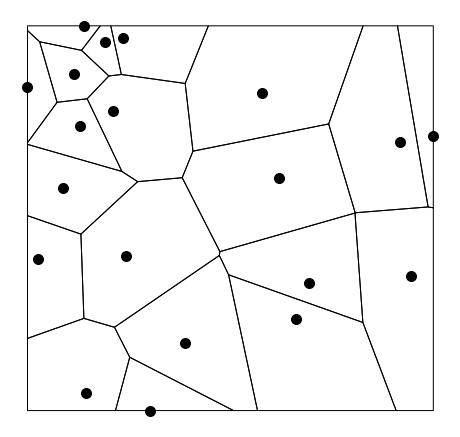

In [60]:
def random_points(n):
    import random, string
    # Create an empty GeoDataFrame
    gdf = gpd.GeoDataFrame(columns=['geometry'])

    # Generate 10 random points and add them to the GeoDataFrame
    for i in range(n):
        x = random.uniform(-90, 90)
        y = random.uniform(-90, 90)
        point = Point(x, y)
        temp_gdf = gpd.GeoDataFrame(geometry=[point])
        temp_gdf['label']=random.choice(string.ascii_letters)
        #temp_gdf.crs = {'init': 'epsg:4326'}
        gdf = pd.concat([gdf,temp_gdf])

    # Set the CRS (coordinate reference system)
    gdf.crs = {'init': 'epsg:4326'}
    return gdf

rand=random_points(20)
ax = rand.plot(markersize=100,c='black',figsize=(8,8))
#print(rand)

from libpysal.cg import voronoi_frames
gdf=rand
coordinates = np.column_stack((gdf.geometry.x, gdf.geometry.y))
cells, generators = voronoi_frames(coordinates, clip="extent")   
cells.plot(color='none',ax=ax)
ax.axis('off')

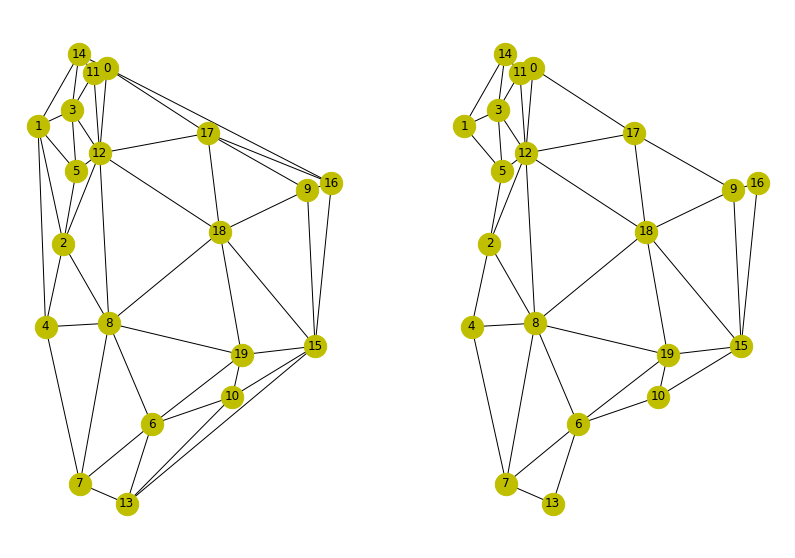

In [62]:
fig,ax=plt.subplots(1,2,figsize=(14,10))
axs=ax.flat
G,pos=delaunay_scipy(rand, key='label')
nx.draw(G, pos, node_size=500, node_color='y', with_labels=True,ax=axs[0])
G,pos=delaunay_pysal(rand, key='label')
nx.draw(G, pos, node_size=500, node_color='y', with_labels=True,ax=axs[1])